# Oe Market Risk Tutorial - Jupyter Notebook

Author: Fabian Arter, Date: 2022-01-29 - 2022-01-30

The aim of this notebook is the explain the main concepts of market risk.

## Introduction
### Returns
#### Historical return types
Returns show how a price of an asset has developed over time. This is measured by comparing the price of the same asset during different periods in time. Returns in finance are almost always calculated as relative returns, not in absolute CHF terms.  
##### Discrete return
The return over a single period in discrete time is calculated as 
\begin{equation}
R(t)=\frac{S(t)-S(t-1)}{S(t-1)} 
\end{equation}

**Discrete returns are not additive but multiplicative**

##### Linear return
Linear return refers to the return over different time periods, whereas the inital starting point P0 remains the same. Note that linear returns are hardly used in practise. 
**Linear returns are additive**


##### Continous return
however, in finance we usually use the contiously compounded log return
\begin{equation}
r(t)=\ln \left (   \frac{S(t)}{S(t-1)}  \right )
\end{equation}

**Continuous returns are additive**

#### Scaling (annualization) of returns
Usually we express returns and volatility in annual terms, therefore we can annualize the daily rate of returns into annual returns. logarithmic return $R$  and a logarithmic rate of return $r$ over a period of time of length $t$ is: 
\begin{equation}
R=rt
\end{equation}
So if $r$ is the daily return and a year has 252 trading days $t$  our annual return is $R$.


#### Excess return

The historical excess return is defined as the returns above the return of a risk free $rf$ asset, such as short term treasury bond issed by a country with the highset credit ratings (AAA).

It is defined as: $Er = r-rf$

#### Expected return
The standard method to estimate the expected returns $\mu$ is the sample mean \={r}
\begin{equation}
\overline{r}=\frac{1}{T}\sum_{t=1}^{T}r_{t}
\end{equation}

#### Return of a portfolio

We can calculate the expected portfolio return by simply taking the single asset weights multiplied by their single expected returns and build the sum of it. In matrix notions. $m$ contains all the expected returns arranged into a vecor and $\omega$ is a vector of weights summing up to unity, so we have 

\begin{equation}
 \mu_{p}=\omega ^{_{T}}m
\end{equation}



### Returns: Code Examples

In [2]:
daily.return.table <- data.frame(
                      date        =c(Sys.Date()-3,Sys.Date()-2,Sys.Date()-1,Sys.Date()), 
                      price.chf   =c(50.5,50,52,53.5))

daily.return.table$dis.r.chf      <- c(NA,diff(daily.return.table$price.chf))
daily.return.table$dis.r.daily    <- daily.return.table$dis.r.chf / c(0,daily.return.table$price.chf[1:nrow(daily.return.table)-1])
daily.return.table$dis.r.cumul    <- c(NA, (daily.return.table$price.chf[2:nrow(daily.return.table)] / daily.return.table$price.chf[1]-1))
daily.return.table$cont.r.daily   <- c(NA, (log(daily.return.table$price.chf[2:nrow(daily.return.table)] / daily.return.table$price.chf[1:nrow(daily.return.table)-1])))


print(daily.return.table)

# discrete daily returns are multiplicative, not additive
discrete.r.total <- prod(as.vector(na.omit(daily.return.table$dis.r.daily)) +1) -1 
print(paste("discrete return overall:",round(discrete.r.total,6)))
print((1+discrete.r.total)*daily.return.table$price.chf[1])

# cumulative daily returns are additive
continous.r.total <- sum(na.omit(daily.return.table$cont.r.daily))
print(paste("continuous return overall:",round(continous.r.total,6)))
print(exp(continous.r.total)*daily.return.table$price.chf[1])


        date price.chf dis.r.chf dis.r.daily dis.r.cumul cont.r.daily
1 2022-01-27      50.5        NA          NA          NA           NA
2 2022-01-28      50.0      -0.5 -0.00990099 -0.00990099 -0.009950331
3 2022-01-29      52.0       2.0  0.04000000  0.02970297  0.039220713
4 2022-01-30      53.5       1.5  0.02884615  0.05940594  0.028437935
[1] "discrete return overall: 0.059406"
[1] 53.5
[1] "continuous return overall: 0.057708"
[1] 53.5


## Volatility & Return Distribution

### Variance vs Volatility
The variance indicates the risk of an asset or of an entire portfolio, it is the standard deviation $\sigma$ (volatility) of returns squared $\sigma^2$. 


### Volatility of a portfolio
The risk of a portfolio can be quantified by computing the variance of the portfolio return, which is equal to $w^T\Sigma w$ where $w$ is the already introduced weight vector and the $\Sigma$ is the covariance matrix.


### Volatility: Codes Examples

In [3]:
install.packages("ggplot2")
install.packages("BatchGetSymbols")
install.packages("dplyr")
library(ggplot2)
library(BatchGetSymbols)
library(dplyr)

#' etlFinData
#'
#' @param start.date Start Date of the historical price data
#' @param end.date  End Date of the historical price data
#' @param input.tickers.df Data Frame with the products we wish to have the prices, this includes the ticker symbol and a friendly name
#' @return a list with two data frames: cumulated.returns.data.long and cumulated.returns.data.long
#' @export
etlFinData <- function(start.date=as.Date("2018-01-01"),
                       end.date=as.Date("2022-01-13"),
                       input.tickers.df = data.frame(ticker=c("LUKN.SW","AIR.PA"),
                                                     friendly.name=c("LUKN.SW","AIRBUS"))
) {
  
  # load data via BatchGetSymbols
  daily.returns.data.long <- BatchGetSymbols::BatchGetSymbols(
    tickers      = as.character(input.tickers.df$ticker),
    first.date   = start.date,
    last.date    = end.date,
    freq.data    = "daily",
    type.return  = "log",
    cache.folder = file.path(tempdir(), 'BGS_Cache') )$df.tickers
  
  
  # add friendly names
  daily.returns.data.long <-  merge(daily.returns.data.long, input.tickers.df, by="ticker")
  
  daily.returns.data.long[is.na(daily.returns.data.long$ret.adjusted.prices),]$ret.adjusted.prices <- 0
  daily.returns.data.long <- na.omit(daily.returns.data.long)
  
  daily.returns.data.long <- data.frame(ref.date        = daily.returns.data.long$ref.date,
                                        friendly.name   = as.character(daily.returns.data.long$friendly.name),
                                        price.adjusted  = daily.returns.data.long$price.adjusted,
                                        daily.return    = daily.returns.data.long$ret.adjusted.prices)
  
  daily.returns.data.wide <- reshape2::dcast(daily.returns.data.long,  ref.date ~ friendly.name, value.var = "daily.return")
  daily.returns.data.wide <- na.omit(daily.returns.data.wide)
  
  # cumulated returns wide
  cumulated.returns.data.wide  <- if(nrow(input.tickers.df) !=1) {
    as.data.frame(cbind(ref.date = daily.returns.data.wide$ref.date, apply(daily.returns.data.wide[,2:ncol(daily.returns.data.wide)], 2, cumsum)))
    
  }
    

  # cumulated returns long
  cumulated.returns.data.long <- if(nrow(input.tickers.df) !=1) {
    cumulated.returns.data.long               <- reshape2::melt(cumulated.returns.data.wide, id.vars=1, measure.vars = 2:ncol(cumulated.returns.data.wide))
    cumulated.returns.data.long$ref.date      <- as.Date(cumulated.returns.data.long$ref.date, origin = "1970-01-01")
    cumulated.returns.data.long$name          <- as.character(cumulated.returns.data.long$variable) ; cumulated.returns.data.long$variable <- NULL
    cumulated.returns.data.long$cumul.return  <- cumulated.returns.data.long$value ; cumulated.returns.data.long$value <- NULL
    cumulated.returns.data.long
  } else {
    data.frame(ref.date = daily.returns.data.long$ref.date, name = daily.returns.data.long$friendly.name, cumul.return=cumsum(daily.returns.data.long$daily.return))
  }
  
  cumulated.returns.data.wide$ref.date      <- as.Date(as.numeric(cumulated.returns.data.wide$ref.date), origin = "1970-01-01")
  
  return(list(daily.returns.data.long     = daily.returns.data.long,
              daily.returns.data.wide     = daily.returns.data.wide,
              cumulated.returns.data.long = cumulated.returns.data.long,
              cumulated.returns.data.wide = cumulated.returns.data.wide))
  
}    

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: rvest
Loading required package: xml2
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





Running BatchGetSymbols for:
   tickers =LUKN.SW, BTC-USD
^GSPC | yahoo (1|1) | Not Cached | Saving cache
LUKN.SW | yahoo (1|2) | Not Cached | Saving cache - Got 98.8% of valid prices | Mas bah tche, que coisa linda!
BTC-USD | yahoo (2|2) | Not Cached | Saving cache - Got 100% of valid prices | Nice!

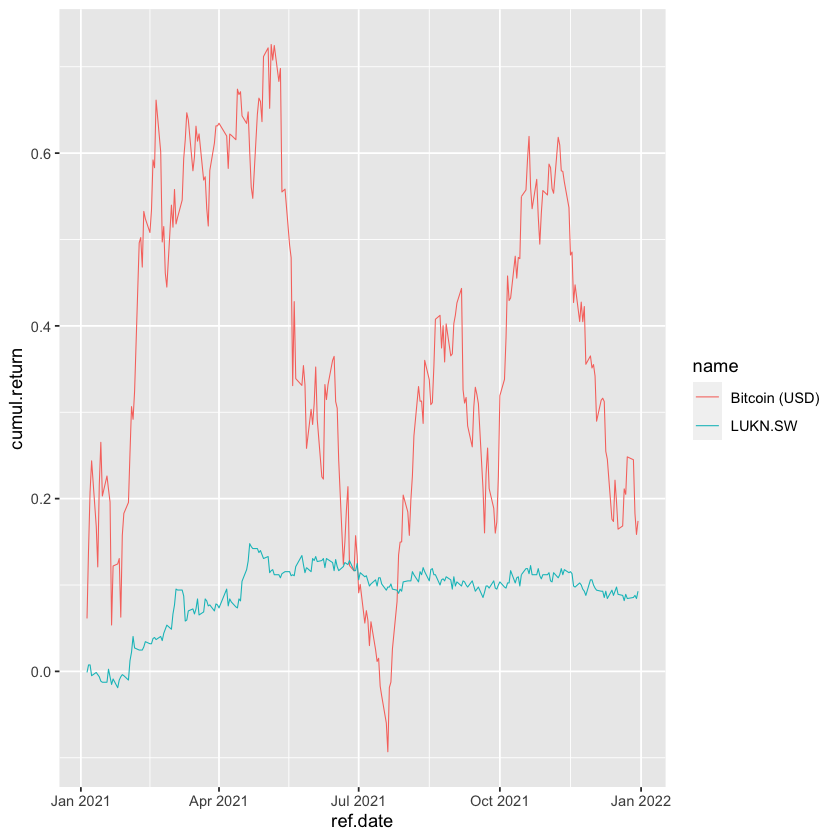

friendly.name min         max        mean        sd          n   q05        
1 Bitcoin (USD) -0.14810708 0.17182056 0.001250456 0.042096202 364 -0.06611552
2 LUKN.SW       -0.02905488 0.02278006 0.000366836 0.007860781 253 -0.01073615
  q01         q95        q99        shapiro.normality.pvalue
1 -0.11807954 0.07199510 0.09735075 0.0001516851            
2 -0.01876611 0.01374109 0.02095903 0.0227303509

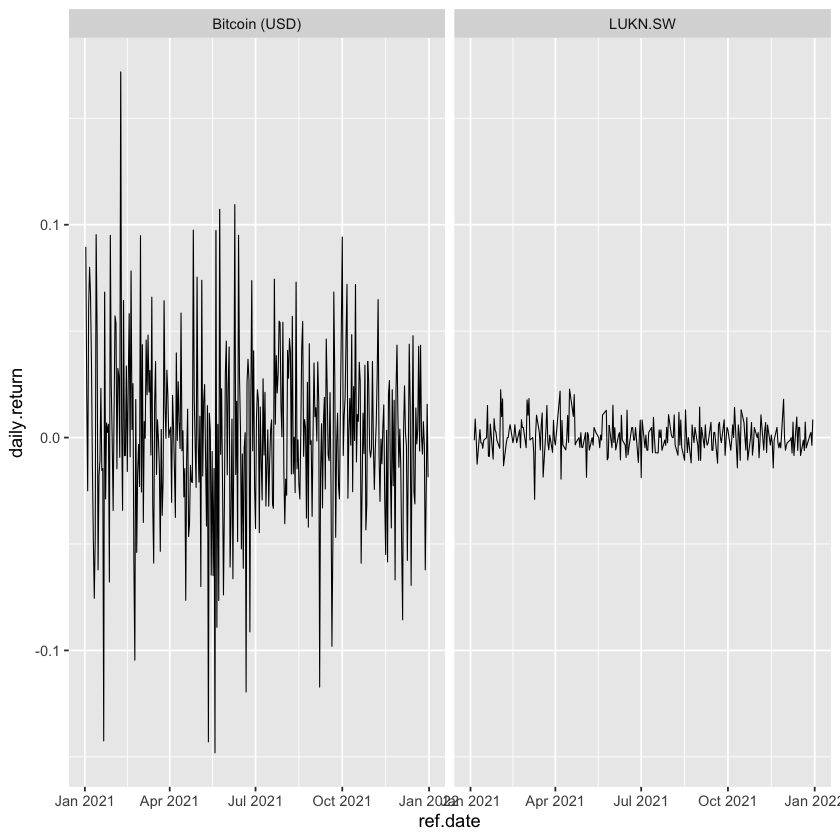


	Shapiro-Wilk normality test

data:  random.returns.example
W = 0.99955, p-value = 0.2928


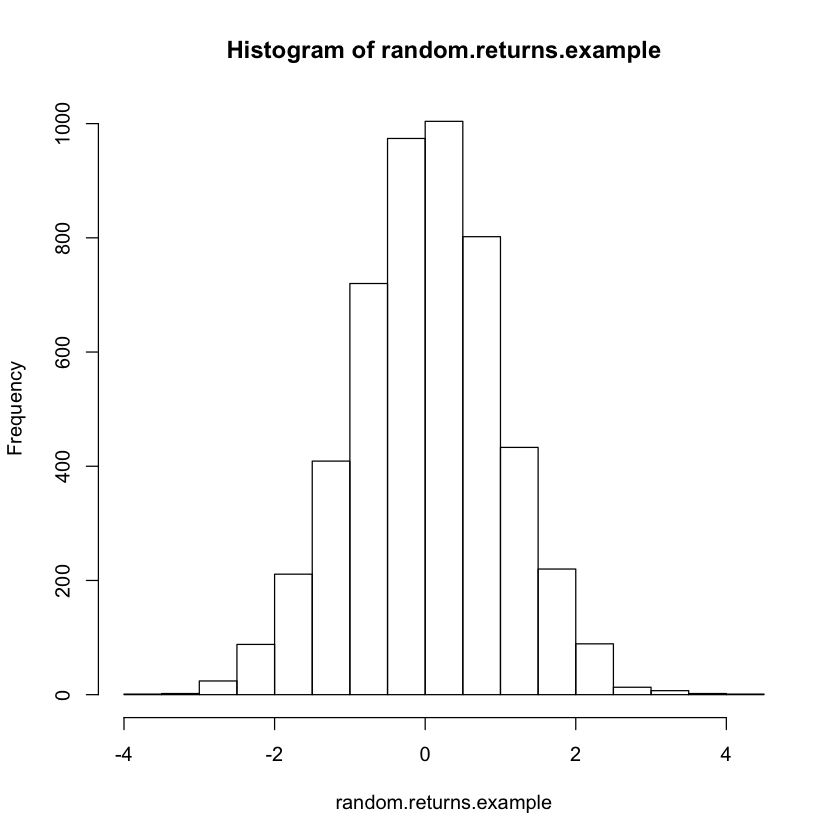

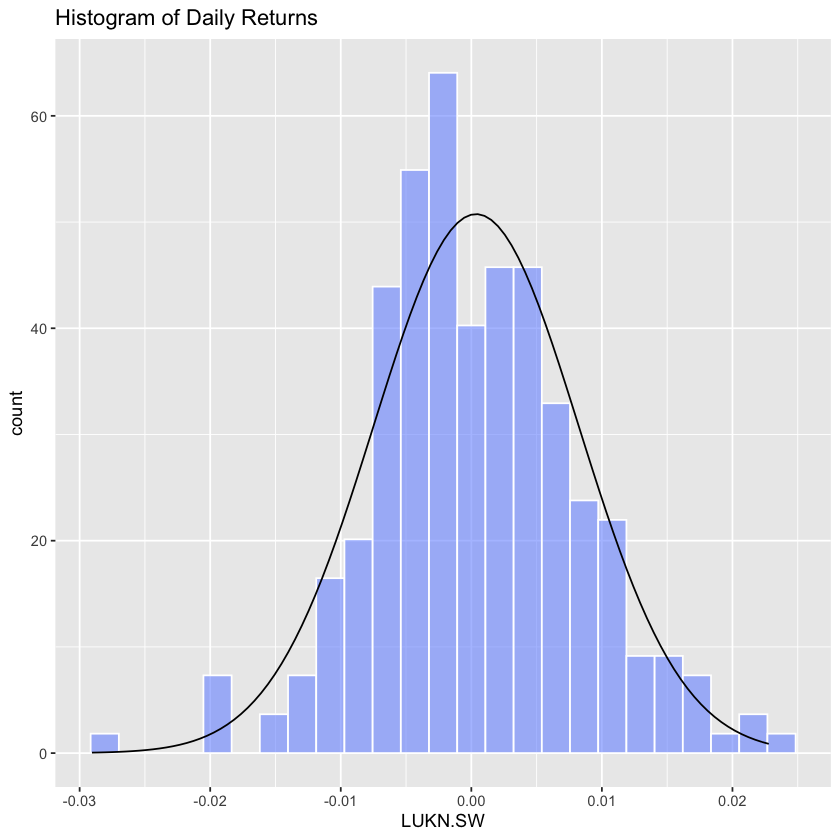

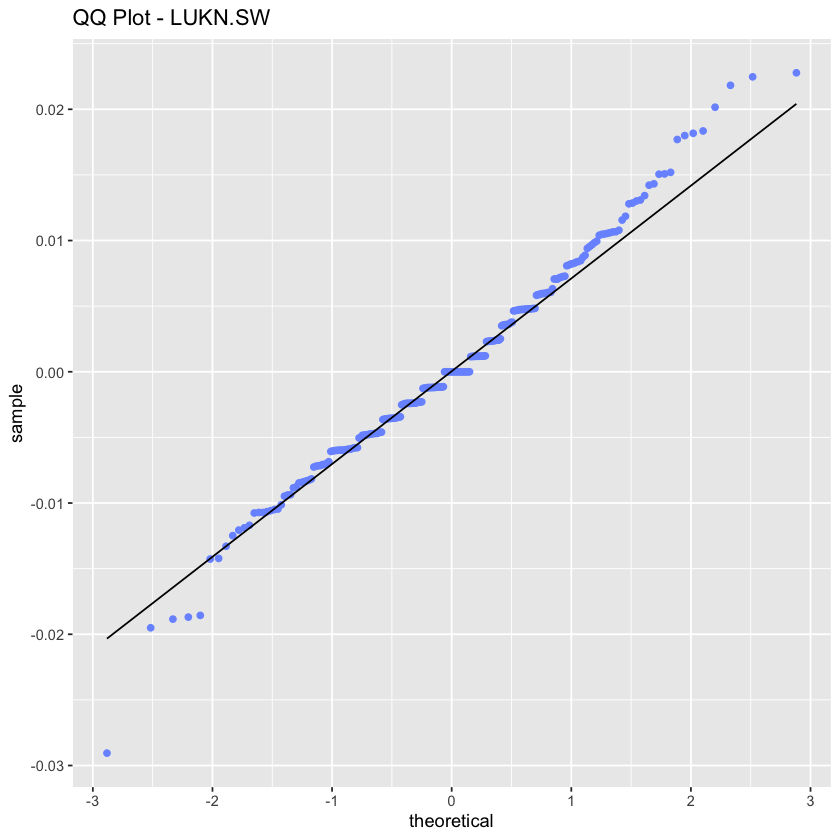

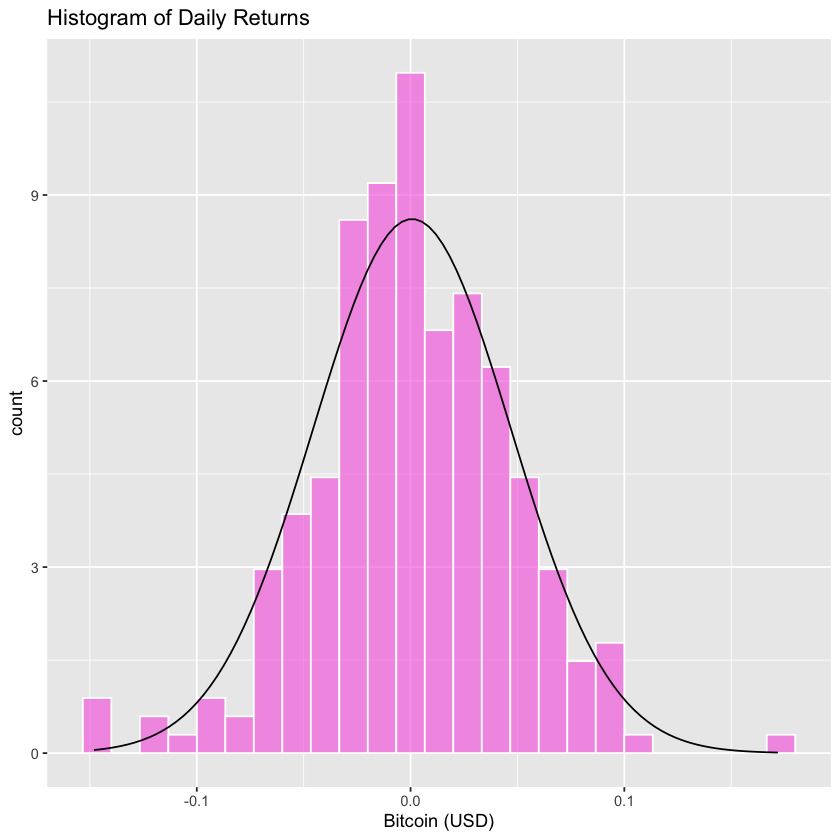

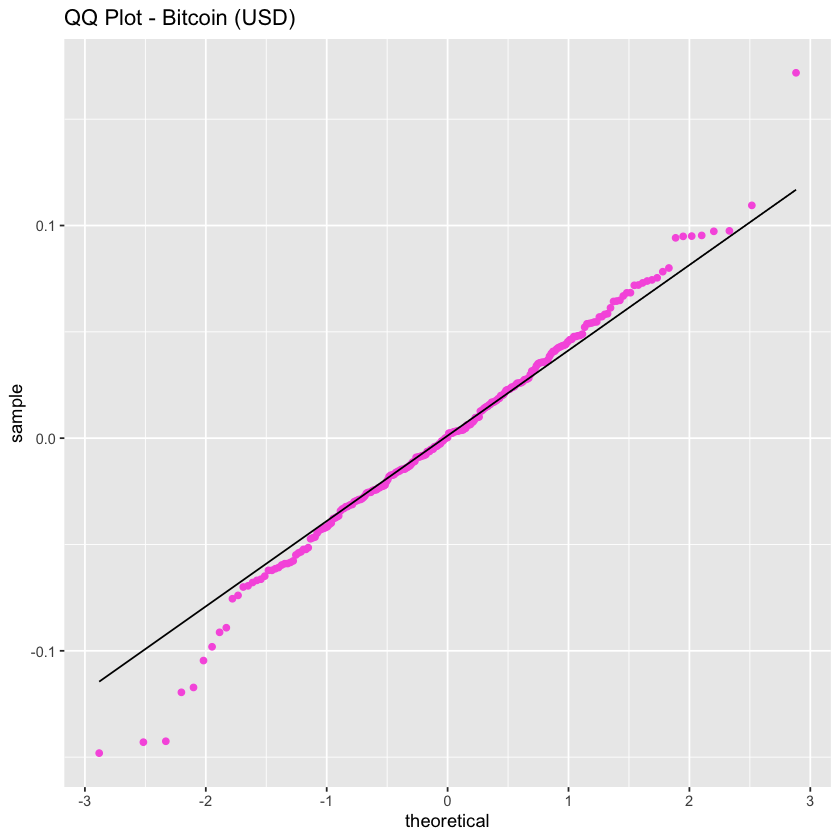

In [4]:
PF.daily.return <- etlFinData(start.date=as.Date("2021-01-01"),
                              end.date=as.Date("2021-12-31"),
                              input.tickers.df = data.frame(ticker=c("LUKN.SW","BTC-USD"),
                                                            friendly.name=c("LUKN.SW","Bitcoin (USD)")))
PF.daily.return.wide <- PF.daily.return$daily.returns.data.wide
PF.daily.return.long <- PF.daily.return$daily.returns.data.long
PF.daily.cumul.long  <- PF.daily.return$cumulated.returns.data.long 


# Cumulated return plot
ggplot(PF.daily.cumul.long, aes(y=cumul.return, x=ref.date, color=name)) +   geom_line(size=0.3)  

# Vola plot
ggplot(PF.daily.return.long, aes(y=daily.return, x=ref.date)) +   geom_line(size=0.3)  + facet_grid(~ friendly.name)
  
PF.daily.return.long %>% group_by(friendly.name) %>% 
  summarise(min = min(daily.return)
            ,max = max(daily.return)
            ,mean = mean(daily.return)
            ,sd = sd(daily.return)
            ,n = n()
            ,q05 = quantile(daily.return, .05)
            ,q01 = quantile(daily.return, .01)
            ,q95 = quantile(daily.return, .95)
            ,q99 = quantile(daily.return, .99)
            ,shapiro.normality.pvalue = as.numeric(shapiro.test(daily.return)[2])
            ) 


# Shapiro-Wilk Test for Normality, 
# Null hypothesis: The data is normally distributed. If p> 0.05, normality can be assumed
random.returns.example <- rnorm(5000)
hist(random.returns.example)
shapiro.test(random.returns.example)

# HISTOGRAM LUKB
  ggplot(PF.daily.return.wide, aes(x=LUKN.SW)) +
  geom_histogram(colour="white", fill="#7997FF", alpha=0.6, position = 'identity', bins=25, aes(y=..density..)) +
  scale_fill_manual(values="white") + theme(legend.title = element_blank()) +
  stat_function(fun = dnorm, args = list(mean = mean(PF.daily.return.wide$LUKN.SW), sd = sd(PF.daily.return.wide$LUKN.SW))) +
  ggtitle("Histogram of Daily Returns")  + ylab("count")

 # QQ Plot - LUKB
 ggplot(PF.daily.return.wide) +
  stat_qq(aes(sample = LUKN.SW),colour = "#7997FF") + stat_qq_line(aes(sample = LUKN.SW)) +
  ggtitle("QQ Plot - LUKN.SW") + xlab("theoretical") + ylab("sample")



   # HISTOGRAM Bitcoin
   ggplot(PF.daily.return.wide, aes(x=`Bitcoin (USD)`)) +
    geom_histogram(colour="white", fill="#F763E0", alpha=0.6, position = 'identity', bins=25, aes(y=..density..)) +
    scale_fill_manual(values="white") + theme(legend.title = element_blank()) +
    stat_function(fun = dnorm, args = list(mean = mean(PF.daily.return.wide$`Bitcoin (USD)`), sd = sd(PF.daily.return.wide$`Bitcoin (USD)`))) +
    ggtitle("Histogram of Daily Returns")  + ylab("count")
  
  # QQ Plot - BITCOIN
  ggplot(PF.daily.return.wide) +
  stat_qq(aes(sample = `Bitcoin (USD)`),colour = "#F763E0") + stat_qq_line(aes(sample = `Bitcoin (USD)`)) +
  ggtitle("QQ Plot - Bitcoin (USD)") + xlab("theoretical") + ylab("sample")


## Covariance

### Sample Covariance
The sample covariance is defined as follows
\begin{equation}
s_{xy}=\frac{1}{n-1}\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y}))
\end{equation}

### Correlation


### Covariance of Portfolio (Covariance Matrix)
The portfolio's covariance is defined as follows

\begin{multline}
\sigma^{2}_p=Var(R_p) 
= Var\left ( \sum_{i=1}^{k}w_i*R_i(t) \right ) 
=Cov\left ( \sum_{i=1}^{k}w_i*R_i(t),\sum_{j=1}^{k}w_j*R_j(t) \right ) \\ 
=\sum_{i=1}^{k}\sum_{j=1}^{k}w_i w_jCov(R_i(t),R_j(t)) 
=w^T\Sigma w
\end{multline}

where $\Sigma$ is the $k \times k$ covariance matrix with entries \(\sigma\) = Cov\( Ri,Rj \).


#### Covariance Matrix Decomposition
A covariance matrix can be decomposed into a volatility vector \(\sigma\) and a correlation matrix $R$:

We first create a diagonal standard deviation matrix $S$, which looks like this:



$S=\begin{pmatrix}
\sigma _{1} &0  &... &0 \\ 
 0& \sigma _{2} &... &0 \\ 
 \vdots &  &  \ddots &0 \\ 
0& ...\ & ...\ & \sigma _{n}
\end{pmatrix}$

 
and the correlation matrix $R$:


$R=\begin{pmatrix}
1 & \rho _{12} &...  &\rho _{1n}\\ 
 \rho _{21} &1& ... &\rho _{2n} \\ 
 \vdots &  &  \ddots & \\ 
\rho _{n1}& ...\ & ...\ & 1
\end{pmatrix}$


So our covariance matrix $\Sigma$ is generated by first multiplying the correlation matrix with the diagonal standard deviation matrix and then again multiplying by the transposed diagonal volatility matrix (as however $S$ is a diagonal matrix, it does not matter whether we take the transposed matrix or not, so $S=S^{^{T}}$). 

$\Sigma =SRS$

This decomposition can be helpful if we want to control the specific inputs, i.e. the correlation or the volatilites. 


### Covariance: Code Examples

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Running BatchGetSymbols for:
   tickers =^IXIC, AAPL, FB, INTC, MSFT, ABNB, ADBE, AMZN, EA
^GSPC | yahoo (1|1) | Found cache file
^IXIC | yahoo (1|9) | Found cache file - Got 100% of valid prices | Got it!
AAPL | yahoo (2|9) | Found cache file - Got 100% of valid prices | You got it!
FB | yahoo (3|9) | Found cache file - Got 100% of valid prices | Got it!
INTC | yahoo (4|9) | Found cache file - Got 100% of valid prices | Nice!
MSFT | yahoo (5|9) | Found cache file - Got 100% of valid prices | Feels good!
ABNB | yahoo (6|9) | Found cache file - Got 100% of valid prices | Good stuff!
ADBE | yahoo (7|9) | Found cache file - Got 100% of valid prices | OK!
AMZN | yahoo (8|9) | Found cache file - Got 100% of valid prices | Good stuff!
EA | yahoo (9|9) | Found cache file - Got 100% of valid prices | Good job!`geom_smooth()` using formula 'y ~ x'


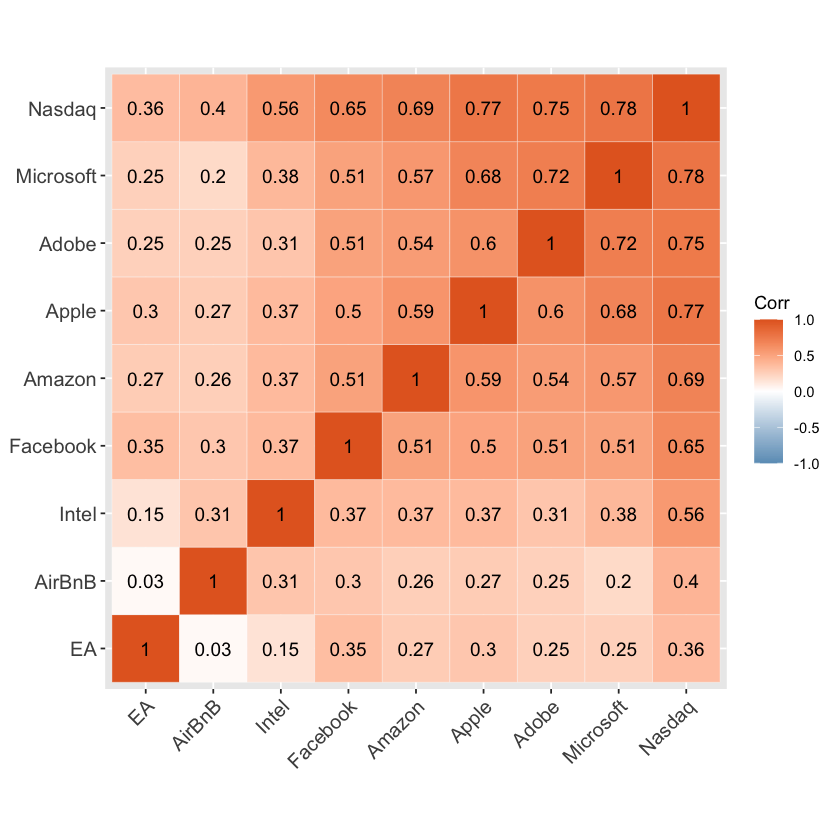

[1] 0.7832184


In [8]:
install.packages("ggcorrplot")
library(ggcorrplot)

PF.daily.return.data <- etlFinData(start.date=as.Date("2021-01-01"),
                                end.date=as.Date("2021-12-31"),
                                input.tickers.df = data.frame(ticker=c("^IXIC","AAPL","FB","INTC","MSFT","ABNB","ADBE","AMZN","EA"),
                                                              friendly.name=c("Nasdaq","Apple","Facebook","Intel","Microsoft","AirBnB","Adobe","Amazon","EA"))) 
  
  PF.daily.return.data.wide <- PF.daily.return.data$daily.returns.data.wide
  
  PF.correl.matrix <- cor(PF.daily.return.data.wide[,2:ncol(PF.daily.return.data.wide)])
  library(ggcorrplot)
  
  ggcorrplot(
    PF.correl.matrix,
    hc.order = TRUE,
    #type = "lower",
    outline.color = "white",
    ggtheme = ggplot2::theme_gray,
    colors = c("#6D9EC1", "white", "#E46726"),
    lab = TRUE
  )

  ggplot(PF.daily.return.data.wide, aes(x=Nasdaq, y=Microsoft)) + geom_point() +
    geom_smooth(method=lm, se=FALSE)
 
# Correlation example Microsoft, Nasdaq
  correl.manual = cov(PF.daily.return.data.wide$Microsoft, PF.daily.return.data.wide$Nasdaq) / (sd(PF.daily.return.data.wide$Microsoft)*sd(PF.daily.return.data.wide$Nasdaq))
  print(correl.manual)

## Value at Risk ##
As defined by Wilmott (2007) <em>Value at Risk (VaR)</em> 
"is an estimate, with a given degree of confidence, of how much on can lose from one's portfolio over a given time horizon"

### Parametrical (delta-normal) VaR ###

#### Parametrical Value at Risk for single Assets ####
The parametrical Value at Risk (VaR) is also called analytical VaR, it is based on a mean-variance or delta-normal approach. 
It basically only requires an estimation of the mean and the volatility of the returns, which are assumed to be normally distributed.

$\Delta$ represents the quantity of the asset hold with price $S$ and volatility $\sigma$.

\begin{equation}
VaR^{param}=-\sigma \Delta S(\delta t)^{1/2}\alpha (1-c)
\end{equation}


where $\alpha\left ( \cdot  \right )$ is the inverse cumulative distribution function for the standardized Normal distribution. 
$(\delta t)$ is the time horizon (usually one to five days) and $c$ is the degree of confidence (e.g. 0.95 or 0.99). 
The mean of the distribution is assumed to be zero (which is reasonable for short time periods, such as in the VaR, which are usually ranging from one to five days).

If we assume that the returns are not autocorrelated, we can simply scale the volatility by $\sqrt{t}$, if we e.g. have a daily volatility $\sigma$ of 1.5\% and a confidence level of 99\% and a holding period of 5 days we get:

$VaR_{5d @0.99}^{param}=-0.015 \times \Delta S \times \sqrt{5} \times 2.33$

#### Parametrical Value at Risk for Portfolios #### 
The parametric VaR of a portfolio can be calculated in the following way:

\begin{equation}
VaR_{PF}^{param}=\upsilon \Pi  \upsilon ^{T}
\end{equation}

where $\upsilon$ is the vector of the single Assets VaR figures and $\Pi $ is the correlation matrix of the assets' returns.

### Historical (Non-parametrical) Value at Risk ###
The nonparametric or historical VaR is simply derived from historical data. This has the advantage that we do not estimate any return distribution functions or worry about volatilities.  

\begin{equation}
VaR_{1-\alpha}^{hist}=R_\alpha
\end{equation}

$VaR_{1-\alpha}$ is the VaR at a confidence level of $1-\alpha$ or in other words the $\alpha$ th's worst return is our VaR. If we have 100 daily returns and we want to know the 95\% VaR, we simply look at the 5th worst daily return, which corresponds to the historical VaR at a 95\% confidence level.

### Conditional Value at Risk or Expected Shortfall ###
Conditional Value-at-Risk or also commonly known as Expected Shortfall, is the amount $\alpha$ which is the conditional expectation of losses above a specified probability level $\beta$. The $\beta$-VaR of a portfolio is the lowest amount $\alpha$ such that, the loss will not be above $\alpha$.  The $\beta$-CVaR
is the conditional expectation of losses exceeding $\alpha$. So the CVaR is the mean of all returns that are beyond (or "worse" than) VaR. Therefore CVaR is always more severe than VaR, which shows also the focus on the more extreme tail risks that are not captured by VaR (as with VaR we do not know how much worse it can go once we have breached VaR). 

Mathematically CVaR can be defined as

\begin{equation}
CVaR_{\alpha }(X)=\frac{1}{\alpha }\int_{0}^{\alpha }VaR_{\beta }(X)d\beta 
\end{equation}

or alternatively 

\begin{equation}
CVaR_{\alpha }(X)=E\left [ X|X\geq VaR_{\alpha }(X) \right ]
\end{equation}

As with VaR, CVaR can be parametrical or non-parametrical. 

### Value at Risk: Code Examples

In [37]:
# Parametric VaR (1 title) - LuKB
daily.vola          <- sd(PF.daily.return.wide$LUKN.SW)
print(paste("daily vola in %:",round(daily.vola*100,4)))
expect.daily.return <- mean(PF.daily.return.wide$LUKN.SW)
print(paste("expect return in %:",round(expect.daily.return*100,4)))
current.price.chf   <- 100
print(paste("current price CHF:",round(current.price.chf,4)))
holding.period.days <- 5
print(paste("Holding Period d:",holding.period.days))
conf.level          <- 0.99
# VaR calculation

param.var.chf <- current.price.chf*(expect.daily.return+qnorm(1-conf.level,0,1)*daily.vola*sqrt(holding.period.days))
print(paste("Param-VaR %:",round(param.var.chf/current.price.chf,6)))
print(paste0("Param-VaR CHF ",holding.period.days,"d: ",round(param.var.chf,3)))
# Historical VaR
#hvar <- abs(quantile(rend,1-a)*valuep)


# Conditional VaR / Expected Shortfall Using Historical Returns
# description calculates the historical Conditional VaR / Expected Shortfall of a portfolio or an asset
# param daily.returns Daily historical returns of a portfolio or single asset
# param alpha.cvar Alpha of the CVaR, this is the confidence level from which on the average of the tail risk is being calculated
# return cvar CVaR of the specific portfolio or asset with the set alpha
histCVaRcalc <- function(asset.weights=1, daily.returns.data.wide, alpha.cvar) {
  i.num = ceiling(alpha.cvar * nrow(daily.returns.data.wide))
  portfolio.returns <- as.matrix(daily.returns.data.wide[,2:length(daily.returns.data.wide)]) %*% c(asset.weights)
  portfolio.returns <- sort(portfolio.returns)
  cvar = mean(portfolio.returns[1:i.num])
  return(cvar)
}



[1] "daily vola in %: 0.7861"
[1] "expect return in %: 0.0367"
[1] "current price CHF: 100"
[1] "Holding Period d: 5"
[1] "Param-VaR %: -0.040524"
[1] "Param-VaR CHF 5d: -4.052"
